# Advanced Descriptive Analytics
## Exchange Rate Analysis Project - Component 7

---

### 🎯 Objectives
- Perform advanced analytical techniques for deeper insights
- Create currency baskets and portfolio analysis
- Calculate comprehensive risk metrics
- Develop currency ranking systems
- Analyze currency transitions and regime changes
- Build investment and hedging recommendations

### 📋 Analysis Checklist
- [ ] Currency basket analysis (major vs emerging)
- [ ] Portfolio optimization and diversification
- [ ] Advanced risk metrics (VaR, CVaR, etc.)
- [ ] Currency scoring and ranking systems
- [ ] Regime analysis and transition detection
- [ ] Investment strategy recommendations

---

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from scipy.optimize import minimize
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import warnings
from datetime import datetime
import json

# Configure settings
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.4f}'.format)
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("📚 Advanced analytics libraries imported successfully!")
print(f"📅 Advanced analysis started: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

📚 Advanced analytics libraries imported successfully!
📅 Advanced analysis started: 2025-08-25 21:29:57


## 7.1 Load Data and Prepare for Advanced Analysis

In [2]:
# Load cleaned dataset
df = pd.read_csv('data/cleaned_exchange_rates.csv')
df['date'] = pd.to_datetime(df['date'])

print("📊 Dataset loaded for advanced analytics:")
print(f"Date range: {df['date'].min()} to {df['date'].max()}")
print(f"Total observations: {len(df):,}")
print(f"Countries: {df['country'].nunique()}")

# Define currency classifications
currency_classifications = {
    'major': {
        'currencies': ['United States', 'United Kingdom', 'Japan', 'Germany', 
                      'France', 'Canada', 'Australia', 'Switzerland'],
        'description': 'Major developed market currencies'
    },
    'emerging': {
        'currencies': ['China', 'India', 'Brazil', 'Russia', 'South Africa', 
                      'Mexico', 'Turkey', 'Indonesia', 'Thailand', 'Malaysia'],
        'description': 'Emerging market currencies'
    },
    'commodity': {
        'currencies': ['Australia', 'Canada', 'Norway', 'New Zealand', 
                      'South Africa', 'Chile', 'Russia'],
        'description': 'Commodity-linked currencies'
    },
    'safe_haven': {
        'currencies': ['Switzerland', 'Japan', 'United States'],
        'description': 'Traditional safe haven currencies'
    }
}

# Add classification to dataframe
def classify_currency(country):
    for category, info in currency_classifications.items():
        if country in info['currencies']:
            return category
    return 'other'

df['currency_type'] = df['country'].apply(classify_currency)

print("\n💱 Currency Classifications:")
for category, info in currency_classifications.items():
    count = (df['currency_type'] == category).sum()
    print(f"• {category.title()}: {len(info['currencies'])} currencies, {count:,} observations")
    print(f"  {info['description']}")

other_count = (df['currency_type'] == 'other').sum()
print(f"• Other: {other_count:,} observations")

📊 Dataset loaded for advanced analytics:
Date range: 2001-03-01 00:00:00 to 2016-09-01 00:00:00
Total observations: 13,923
Countries: 191

💱 Currency Classifications:
• Major: 8 currencies, 441 observations
  Major developed market currencies
• Emerging: 10 currencies, 693 observations
  Emerging market currencies
• Commodity: 7 currencies, 189 observations
  Commodity-linked currencies
• Safe_Haven: 3 currencies, 0 observations
  Traditional safe haven currencies
• Other: 12,600 observations


## 7.2 Currency Basket Analysis

📊 CURRENCY BASKET ANALYSIS

📊 Currency Basket Statistics:
           currencies   avg_return return_volatility var_5pct expected_shortfall skewness
major               8      18.3610          117.1256  -9.8810           -66.6001   5.0202
emerging           10 1672583.4295     12627410.9170  -9.1783           -45.6584   7.4630
commodity           7       0.3283            7.5607  -9.2463           -12.7899   1.6136
safe_haven          3      -0.4243            5.0180  -7.7037           -10.5662  -0.0134

🏆 Basket Rankings:
Best Risk-Adjusted Returns: Major (0.1568)
Lowest Volatility: Safe_Haven (5.0180%)
Best VaR (5%): Safe_Haven (-7.7037%)


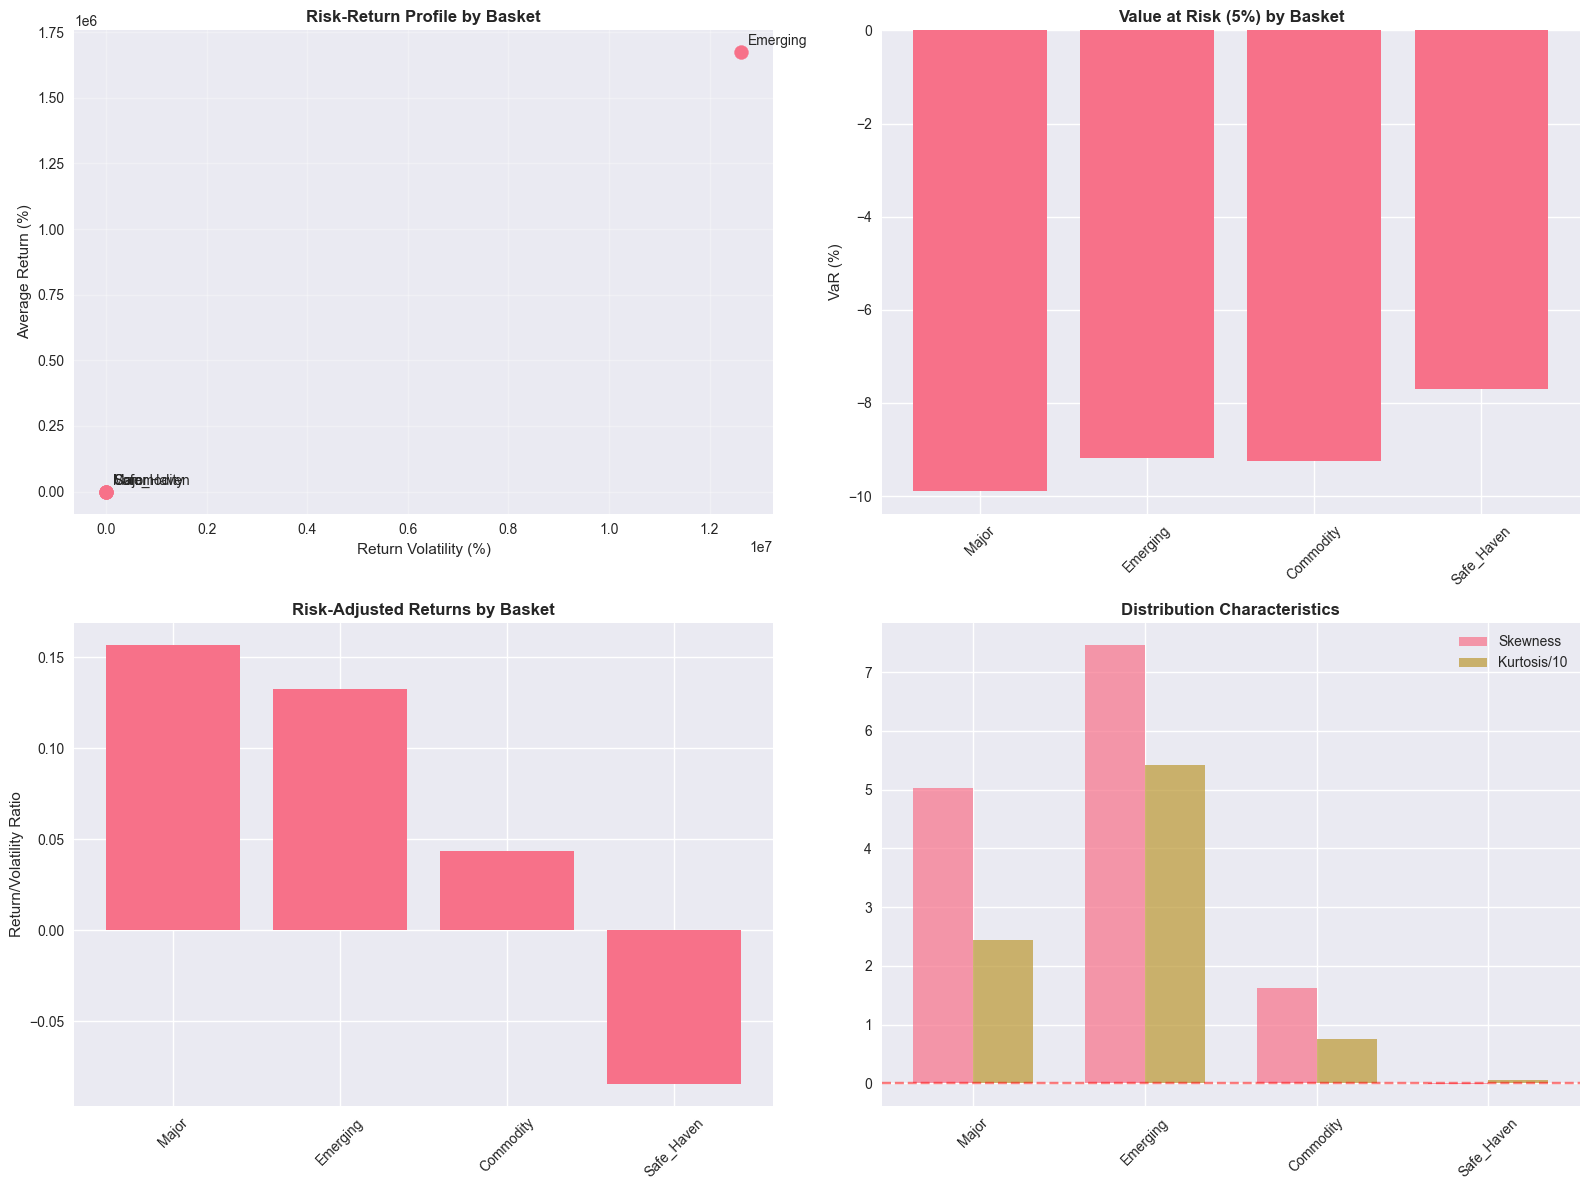

In [3]:
# Analyze currency baskets by type
print("📊 CURRENCY BASKET ANALYSIS")
print("=" * 50)

def analyze_currency_basket(data, basket_name, currencies):
    """Analyze a basket of currencies"""
    basket_data = data[data['country'].isin(currencies)]
    
    if len(basket_data) == 0:
        return None
    
    # Calculate basket statistics
    basket_stats = {
        'name': basket_name,
        'currencies': len(currencies),
        'observations': len(basket_data),
        'avg_exchange_rate': basket_data['exchange_rate'].mean(),
        'median_exchange_rate': basket_data['exchange_rate'].median(),
        'std_exchange_rate': basket_data['exchange_rate'].std(),
        'avg_return': basket_data['quarterly_return'].mean(),
        'return_volatility': basket_data['quarterly_return'].std(),
        'avg_volatility_4q': basket_data['volatility_4q'].mean(),
        'min_return': basket_data['quarterly_return'].min(),
        'max_return': basket_data['quarterly_return'].max(),
        'skewness': basket_data['quarterly_return'].skew(),
        'kurtosis': basket_data['quarterly_return'].kurtosis()
    }
    
    # Calculate Value at Risk (5%)
    returns = basket_data['quarterly_return'].dropna()
    if len(returns) > 0:
        basket_stats['var_5pct'] = np.percentile(returns, 5)
        basket_stats['var_1pct'] = np.percentile(returns, 1)
        
        # Expected Shortfall (Conditional VaR)
        var_5 = basket_stats['var_5pct']
        basket_stats['expected_shortfall'] = returns[returns <= var_5].mean()
    
    return basket_stats

# Analyze each currency basket
basket_results = {}

for category, info in currency_classifications.items():
    result = analyze_currency_basket(df, category, info['currencies'])
    if result:
        basket_results[category] = result

# Display basket analysis results
if basket_results:
    basket_df = pd.DataFrame(basket_results).T
    basket_df = basket_df.round(4)
    
    print("\n📊 Currency Basket Statistics:")
    display_cols = ['currencies', 'avg_return', 'return_volatility', 
                   'var_5pct', 'expected_shortfall', 'skewness']
    print(basket_df[display_cols].to_string())
    
    # Basket rankings
    print("\n🏆 Basket Rankings:")
    
    # Best risk-adjusted return (Sharpe-like ratio)
    basket_df['risk_adj_return'] = basket_df['avg_return'] / basket_df['return_volatility']
    best_risk_adj = basket_df['risk_adj_return'].idxmax()
    print(f"Best Risk-Adjusted Returns: {best_risk_adj.title()} ({basket_df.loc[best_risk_adj, 'risk_adj_return']:.4f})")
    
    # Lowest volatility
    lowest_vol = basket_df['return_volatility'].idxmin()
    print(f"Lowest Volatility: {lowest_vol.title()} ({basket_df.loc[lowest_vol, 'return_volatility']:.4f}%)")
    
    # Best VaR (least negative)
    best_var = basket_df['var_5pct'].idxmax()
    print(f"Best VaR (5%): {best_var.title()} ({basket_df.loc[best_var, 'var_5pct']:.4f}%)")
    
    # Visualize basket comparison
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # 1. Return vs Volatility
    axes[0, 0].scatter(basket_df['return_volatility'], basket_df['avg_return'], s=100)
    for i, basket in enumerate(basket_df.index):
        axes[0, 0].annotate(basket.title(), 
                           (basket_df.loc[basket, 'return_volatility'], basket_df.loc[basket, 'avg_return']),
                           xytext=(5, 5), textcoords='offset points')
    axes[0, 0].set_xlabel('Return Volatility (%)')
    axes[0, 0].set_ylabel('Average Return (%)')
    axes[0, 0].set_title('Risk-Return Profile by Basket', fontweight='bold')
    axes[0, 0].grid(True, alpha=0.3)
    
    # 2. VaR comparison
    axes[0, 1].bar(range(len(basket_df)), basket_df['var_5pct'])
    axes[0, 1].set_xticks(range(len(basket_df)))
    axes[0, 1].set_xticklabels([b.title() for b in basket_df.index], rotation=45)
    axes[0, 1].set_title('Value at Risk (5%) by Basket', fontweight='bold')
    axes[0, 1].set_ylabel('VaR (%)')
    
    # 3. Risk-adjusted returns
    axes[1, 0].bar(range(len(basket_df)), basket_df['risk_adj_return'])
    axes[1, 0].set_xticks(range(len(basket_df)))
    axes[1, 0].set_xticklabels([b.title() for b in basket_df.index], rotation=45)
    axes[1, 0].set_title('Risk-Adjusted Returns by Basket', fontweight='bold')
    axes[1, 0].set_ylabel('Return/Volatility Ratio')
    
    # 4. Distribution characteristics
    x_pos = np.arange(len(basket_df))
    width = 0.35
    
    axes[1, 1].bar(x_pos - width/2, basket_df['skewness'], width, label='Skewness', alpha=0.7)
    axes[1, 1].bar(x_pos + width/2, basket_df['kurtosis']/10, width, label='Kurtosis/10', alpha=0.7)
    axes[1, 1].set_xticks(x_pos)
    axes[1, 1].set_xticklabels([b.title() for b in basket_df.index], rotation=45)
    axes[1, 1].set_title('Distribution Characteristics', fontweight='bold')
    axes[1, 1].legend()
    axes[1, 1].axhline(y=0, color='red', linestyle='--', alpha=0.5)
    
    plt.tight_layout()
    plt.show()
else:
    print("⚠️ No basket results to display")

## 7.3 Portfolio Optimization Analysis

In [4]:
# Portfolio optimization for currency diversification
print("📊 PORTFOLIO OPTIMIZATION ANALYSIS")
print("=" * 50)

def create_currency_portfolio(data, currencies, method='equal_weight'):
    """Create and analyze currency portfolio"""
    # Filter data for selected currencies
    portfolio_data = data[data['country'].isin(currencies)]
    
    # Create returns matrix
    returns_matrix = portfolio_data.pivot_table(
        index='date', 
        columns='country', 
        values='quarterly_return'
    )
    
    # Remove currencies with insufficient data
    min_observations = 10
    valid_currencies = returns_matrix.columns[returns_matrix.count() >= min_observations]
    returns_matrix = returns_matrix[valid_currencies]
    
    if len(valid_currencies) < 2:
        return None
    
    # Calculate correlation matrix
    correlation_matrix = returns_matrix.corr()
    
    # Calculate portfolio statistics
    if method == 'equal_weight':
        weights = np.ones(len(valid_currencies)) / len(valid_currencies)
    elif method == 'min_variance':
        # Minimum variance portfolio
        cov_matrix = returns_matrix.cov()
        
        def portfolio_variance(weights, cov_matrix):
            return np.dot(weights.T, np.dot(cov_matrix, weights))
        
        # Constraints: weights sum to 1, all weights >= 0
        constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
        bounds = tuple((0, 1) for _ in range(len(valid_currencies)))
        
        # Initial guess: equal weights
        x0 = np.ones(len(valid_currencies)) / len(valid_currencies)
        
        try:
            result = minimize(portfolio_variance, x0, args=(cov_matrix,), 
                            method='SLSQP', bounds=bounds, constraints=constraints)
            weights = result.x if result.success else x0
        except:
            weights = x0
    
    # Calculate portfolio returns
    portfolio_returns = (returns_matrix * weights).sum(axis=1)
    
    # Portfolio statistics
    portfolio_stats = {
        'currencies': list(valid_currencies),
        'weights': dict(zip(valid_currencies, weights)),
        'num_currencies': len(valid_currencies),
        'avg_return': portfolio_returns.mean(),
        'volatility': portfolio_returns.std(),
        'sharpe_ratio': portfolio_returns.mean() / portfolio_returns.std() if portfolio_returns.std() > 0 else 0,
        'var_5pct': np.percentile(portfolio_returns.dropna(), 5),
        'max_drawdown': None,  # Simplified for this analysis
        'avg_correlation': correlation_matrix.values[np.triu_indices_from(correlation_matrix.values, k=1)].mean()
    }
    
    return portfolio_stats

# Create portfolios for different currency baskets
portfolio_results = {}

for category, info in currency_classifications.items():
    if len(info['currencies']) >= 3:  # Need at least 3 currencies for meaningful portfolio
        # Equal weight portfolio
        eq_portfolio = create_currency_portfolio(df, info['currencies'], 'equal_weight')
        if eq_portfolio:
            portfolio_results[f"{category}_equal"] = eq_portfolio
        
        # Minimum variance portfolio
        mv_portfolio = create_currency_portfolio(df, info['currencies'], 'min_variance')
        if mv_portfolio:
            portfolio_results[f"{category}_minvar"] = mv_portfolio

# Display portfolio results
if portfolio_results:
    print("\n📊 Portfolio Analysis Results:")
    
    portfolio_df = pd.DataFrame(portfolio_results).T
    portfolio_df = portfolio_df.round(4)
    
    display_cols = ['num_currencies', 'avg_return', 'volatility', 
                   'sharpe_ratio', 'var_5pct', 'avg_correlation']
    print(portfolio_df[display_cols].to_string())
    
    # Portfolio rankings
    print("\n🏆 Portfolio Rankings:")
    
    best_sharpe = portfolio_df['sharpe_ratio'].idxmax()
    print(f"Best Sharpe Ratio: {best_sharpe} ({portfolio_df.loc[best_sharpe, 'sharpe_ratio']:.4f})")
    
    lowest_vol = portfolio_df['volatility'].idxmin()
    print(f"Lowest Volatility: {lowest_vol} ({portfolio_df.loc[lowest_vol, 'volatility']:.4f}%)")
    
    best_var = portfolio_df['var_5pct'].idxmax()
    print(f"Best VaR: {best_var} ({portfolio_df.loc[best_var, 'var_5pct']:.4f}%)")
    
    # Diversification benefits
    print("\n📊 Diversification Analysis:")
    for portfolio_name, stats in portfolio_results.items():
        if stats['avg_correlation'] < 0.5:
            diversification = "High"
        elif stats['avg_correlation'] < 0.7:
            diversification = "Moderate"
        else:
            diversification = "Low"
        
        print(f"{portfolio_name}: Avg correlation = {stats['avg_correlation']:.3f} ({diversification} diversification)")
else:
    print("⚠️ No portfolio results to display")

📊 PORTFOLIO OPTIMIZATION ANALYSIS

📊 Portfolio Analysis Results:
                  num_currencies  avg_return   volatility sharpe_ratio var_5pct avg_correlation
major_equal                    6     10.6228      20.0216       0.5306  -4.4226          0.1970
major_minvar                   6      0.1235       3.0685       0.0403  -4.0092          0.1970
emerging_equal                10 841601.8093 1849773.4614       0.4550  -3.9742          0.2591
emerging_minvar               10 841601.8093 1849773.4614       0.4550  -3.9742          0.2591
commodity_equal                7      0.2912       5.1245       0.0568  -5.5857          0.5394
commodity_minvar               7     -0.0596       4.9421      -0.0121  -6.5371          0.5394
safe_haven_equal               2     -0.4243       3.9608      -0.1071  -5.9533          0.2411
safe_haven_minvar              2     -0.3944       3.9490      -0.0999  -5.8069          0.2411

🏆 Portfolio Rankings:
Best Sharpe Ratio: major_equal (0.5306)
Lowest V

## 7.4 Advanced Risk Metrics

📊 ADVANCED RISK METRICS

📊 Advanced Risk Metrics:
       country  var_5pct  es_5pct  max_drawdown  sharpe_ratio  sortino_ratio  calmar_ratio
United Kingdom   -6.0367  -6.4785      -31.2588        0.0613         0.1337        0.0086
         Japan   -6.7546  -9.1096      -42.5882       -0.0252        -0.0423        0.0029
        Canada   -6.6641  -8.3161      -39.5262       -0.0214        -0.0508        0.0029
     Australia   -8.7144 -13.4599      -53.0066       -0.0517        -0.0880        0.0068
   Switzerland   -7.8824 -10.9249      -53.2294       -0.1393        -0.2042        0.0136
         China   -2.0118  -2.6084      -26.7514       -0.2993        -0.3857        0.0127

🏆 Risk Rankings:
Best Sharpe Ratio: United Kingdom (0.0613)
Best Sortino Ratio: United Kingdom (0.1337)
Best Calmar Ratio: Switzerland (0.0136)
Best VaR (5%): China (-2.0118%)
Lowest Max Drawdown: China (-26.7514%)


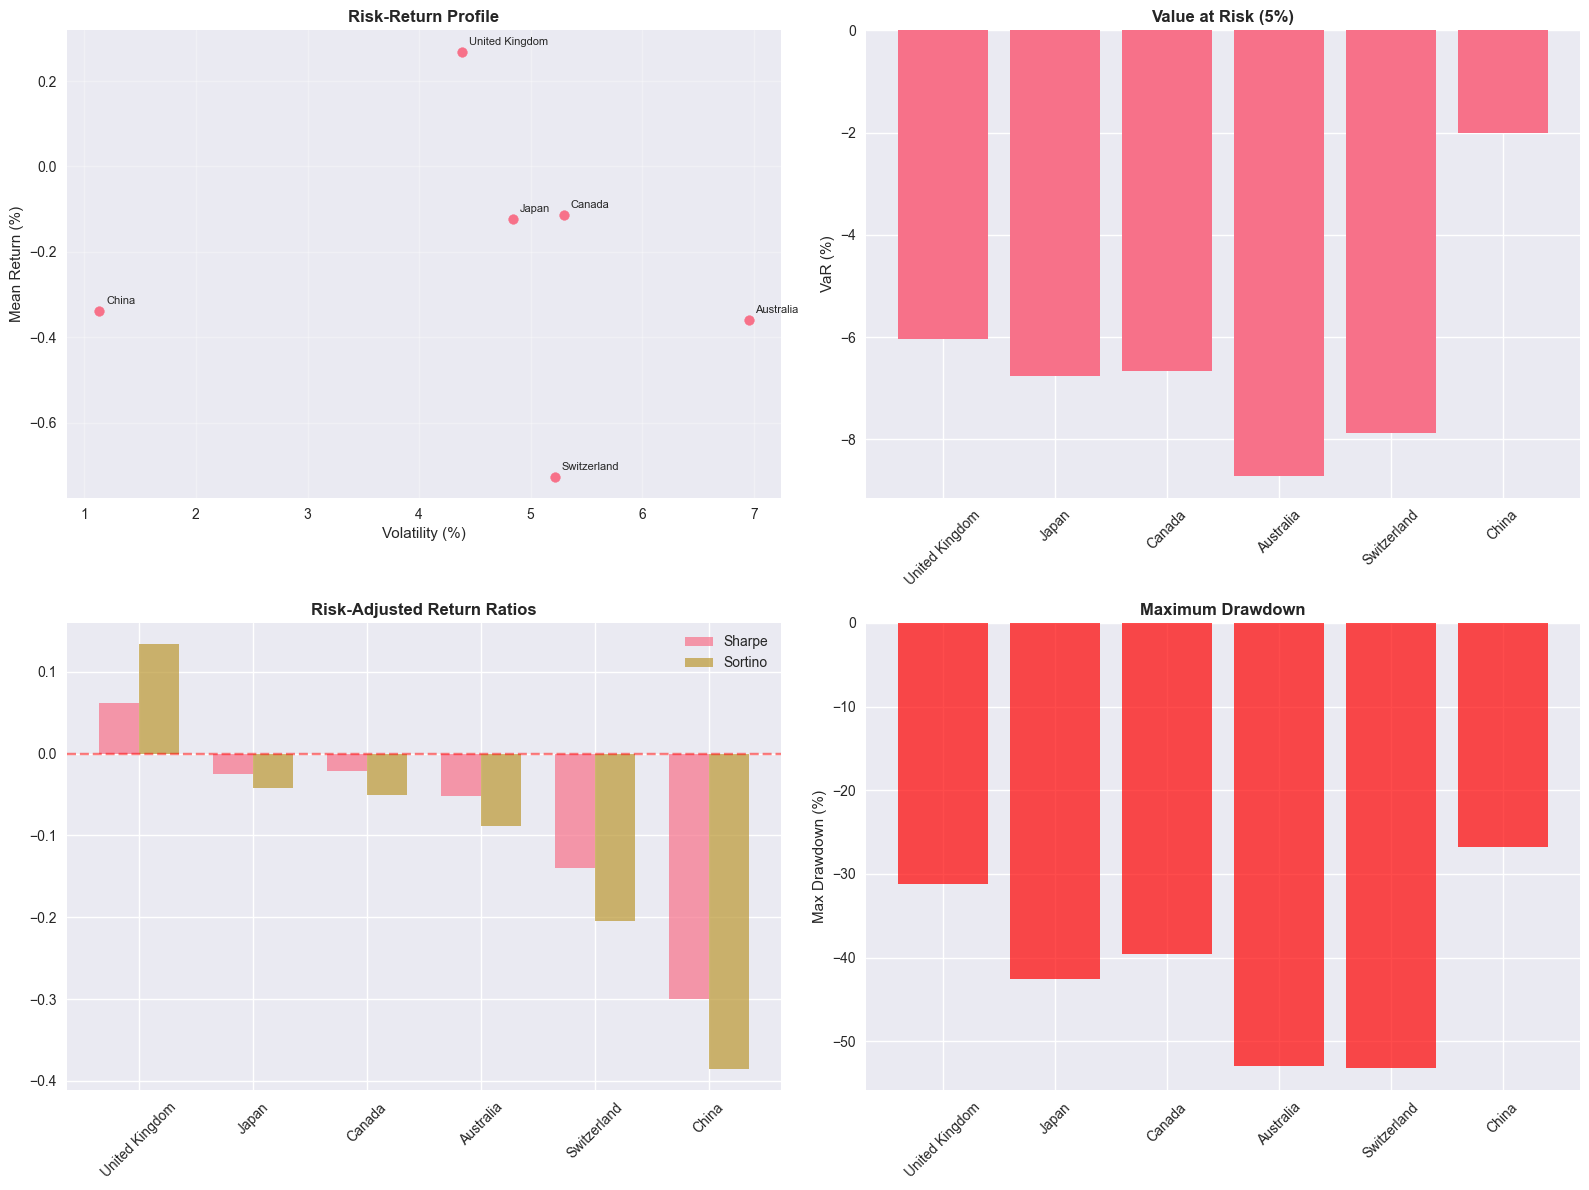

In [5]:
# Calculate comprehensive risk metrics
print("📊 ADVANCED RISK METRICS")
print("=" * 50)

def calculate_advanced_risk_metrics(returns_series, confidence_levels=[0.01, 0.05, 0.10]):
    """Calculate comprehensive risk metrics"""
    returns = returns_series.dropna()
    
    if len(returns) < 10:
        return None
    
    metrics = {}
    
    # Basic statistics
    metrics['mean'] = returns.mean()
    metrics['std'] = returns.std()
    metrics['skewness'] = returns.skew()
    metrics['kurtosis'] = returns.kurtosis()
    
    # Value at Risk (VaR) at different confidence levels
    for cl in confidence_levels:
        metrics[f'var_{int(cl*100)}pct'] = np.percentile(returns, cl * 100)
    
    # Expected Shortfall (Conditional VaR)
    for cl in confidence_levels:
        var_threshold = metrics[f'var_{int(cl*100)}pct']
        tail_returns = returns[returns <= var_threshold]
        if len(tail_returns) > 0:
            metrics[f'es_{int(cl*100)}pct'] = tail_returns.mean()
        else:
            metrics[f'es_{int(cl*100)}pct'] = var_threshold
    
    # Maximum Drawdown (simplified for quarterly data)
    cumulative_returns = (1 + returns / 100).cumprod()
    rolling_max = cumulative_returns.expanding().max()
    drawdown = (cumulative_returns - rolling_max) / rolling_max * 100
    metrics['max_drawdown'] = drawdown.min()
    
    # Downside deviation
    downside_returns = returns[returns < 0]
    metrics['downside_deviation'] = downside_returns.std() if len(downside_returns) > 0 else 0
    
    # Sharpe ratio (assuming risk-free rate = 0)
    metrics['sharpe_ratio'] = metrics['mean'] / metrics['std'] if metrics['std'] > 0 else 0
    
    # Sortino ratio
    metrics['sortino_ratio'] = metrics['mean'] / metrics['downside_deviation'] if metrics['downside_deviation'] > 0 else 0
    
    # Calmar ratio (return/max drawdown)
    metrics['calmar_ratio'] = abs(metrics['mean'] / metrics['max_drawdown']) if metrics['max_drawdown'] < 0 else 0
    
    # Tail ratio (95th percentile / 5th percentile)
    p95 = np.percentile(returns, 95)
    p5 = np.percentile(returns, 5)
    metrics['tail_ratio'] = abs(p95 / p5) if p5 != 0 else np.inf
    
    return metrics

# Calculate risk metrics for major currencies
major_currencies = ['United States', 'United Kingdom', 'Japan', 'Germany', 
                   'Canada', 'Australia', 'Switzerland', 'China']

risk_metrics_results = []

for country in major_currencies:
    country_data = df[df['country'] == country]
    if len(country_data) >= 10:
        risk_metrics = calculate_advanced_risk_metrics(country_data['quarterly_return'])
        if risk_metrics:
            risk_metrics['country'] = country
            risk_metrics_results.append(risk_metrics)

if risk_metrics_results:
    risk_df = pd.DataFrame(risk_metrics_results)
    risk_df = risk_df.round(4)
    
    print("\n📊 Advanced Risk Metrics:")
    display_cols = ['country', 'var_5pct', 'es_5pct', 'max_drawdown', 
                   'sharpe_ratio', 'sortino_ratio', 'calmar_ratio']
    print(risk_df[display_cols].to_string(index=False))
    
    # Risk rankings
    print("\n🏆 Risk Rankings:")
    
    # Best risk-adjusted performance
    best_sharpe = risk_df.loc[risk_df['sharpe_ratio'].idxmax()]
    print(f"Best Sharpe Ratio: {best_sharpe['country']} ({best_sharpe['sharpe_ratio']:.4f})")
    
    best_sortino = risk_df.loc[risk_df['sortino_ratio'].idxmax()]
    print(f"Best Sortino Ratio: {best_sortino['country']} ({best_sortino['sortino_ratio']:.4f})")
    
    best_calmar = risk_df.loc[risk_df['calmar_ratio'].idxmax()]
    print(f"Best Calmar Ratio: {best_calmar['country']} ({best_calmar['calmar_ratio']:.4f})")
    
    # Lowest risk metrics
    best_var = risk_df.loc[risk_df['var_5pct'].idxmax()]
    print(f"Best VaR (5%): {best_var['country']} ({best_var['var_5pct']:.4f}%)")
    
    lowest_drawdown = risk_df.loc[risk_df['max_drawdown'].idxmax()]
    print(f"Lowest Max Drawdown: {lowest_drawdown['country']} ({lowest_drawdown['max_drawdown']:.4f}%)")
    
    # Visualize risk metrics
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # 1. Risk-return scatter
    axes[0, 0].scatter(risk_df['std'], risk_df['mean'])
    for i, country in enumerate(risk_df['country']):
        axes[0, 0].annotate(country, (risk_df['std'].iloc[i], risk_df['mean'].iloc[i]),
                           xytext=(5, 5), textcoords='offset points', fontsize=8)
    axes[0, 0].set_xlabel('Volatility (%)')
    axes[0, 0].set_ylabel('Mean Return (%)')
    axes[0, 0].set_title('Risk-Return Profile', fontweight='bold')
    axes[0, 0].grid(True, alpha=0.3)
    
    # 2. VaR comparison
    axes[0, 1].bar(range(len(risk_df)), risk_df['var_5pct'])
    axes[0, 1].set_xticks(range(len(risk_df)))
    axes[0, 1].set_xticklabels(risk_df['country'], rotation=45)
    axes[0, 1].set_title('Value at Risk (5%)', fontweight='bold')
    axes[0, 1].set_ylabel('VaR (%)')
    
    # 3. Sharpe vs Sortino ratios
    x_pos = np.arange(len(risk_df))
    width = 0.35
    
    axes[1, 0].bar(x_pos - width/2, risk_df['sharpe_ratio'], width, label='Sharpe', alpha=0.7)
    axes[1, 0].bar(x_pos + width/2, risk_df['sortino_ratio'], width, label='Sortino', alpha=0.7)
    axes[1, 0].set_xticks(x_pos)
    axes[1, 0].set_xticklabels(risk_df['country'], rotation=45)
    axes[1, 0].set_title('Risk-Adjusted Return Ratios', fontweight='bold')
    axes[1, 0].legend()
    axes[1, 0].axhline(y=0, color='red', linestyle='--', alpha=0.5)
    
    # 4. Maximum drawdown
    axes[1, 1].bar(range(len(risk_df)), risk_df['max_drawdown'], color='red', alpha=0.7)
    axes[1, 1].set_xticks(range(len(risk_df)))
    axes[1, 1].set_xticklabels(risk_df['country'], rotation=45)
    axes[1, 1].set_title('Maximum Drawdown', fontweight='bold')
    axes[1, 1].set_ylabel('Max Drawdown (%)')
    
    plt.tight_layout()
    plt.show()
else:
    print("⚠️ No risk metrics results to display")

## 7.5 Currency Scoring and Ranking System

📊 CURRENCY SCORING AND RANKING SYSTEM

🏆 TOP 15 CURRENCY RANKINGS:
   rank              country  composite_score  stability_score  performance_score  risk_score  data_completeness
 5.0000      Antigua-Barbuda          75.5283         100.0000             0.0000     99.5045             1.0000
 5.0000              Bahamas          75.5283         100.0000             0.0000     99.5045             1.0000
 5.0000              Bermuda          75.5283         100.0000             0.0000     99.5045             1.0000
 5.0000              Grenada          75.5283         100.0000             0.0000     99.5045             1.0000
 5.0000    Marshalls Islands          75.5283         100.0000             0.0000     99.5045             1.0000
 5.0000           Micronesia          75.5283         100.0000             0.0000     99.5045             1.0000
 5.0000 Netherlands Antilles          75.5283         100.0000             0.0000     99.5045             1.0000
 5.0000               Panama 

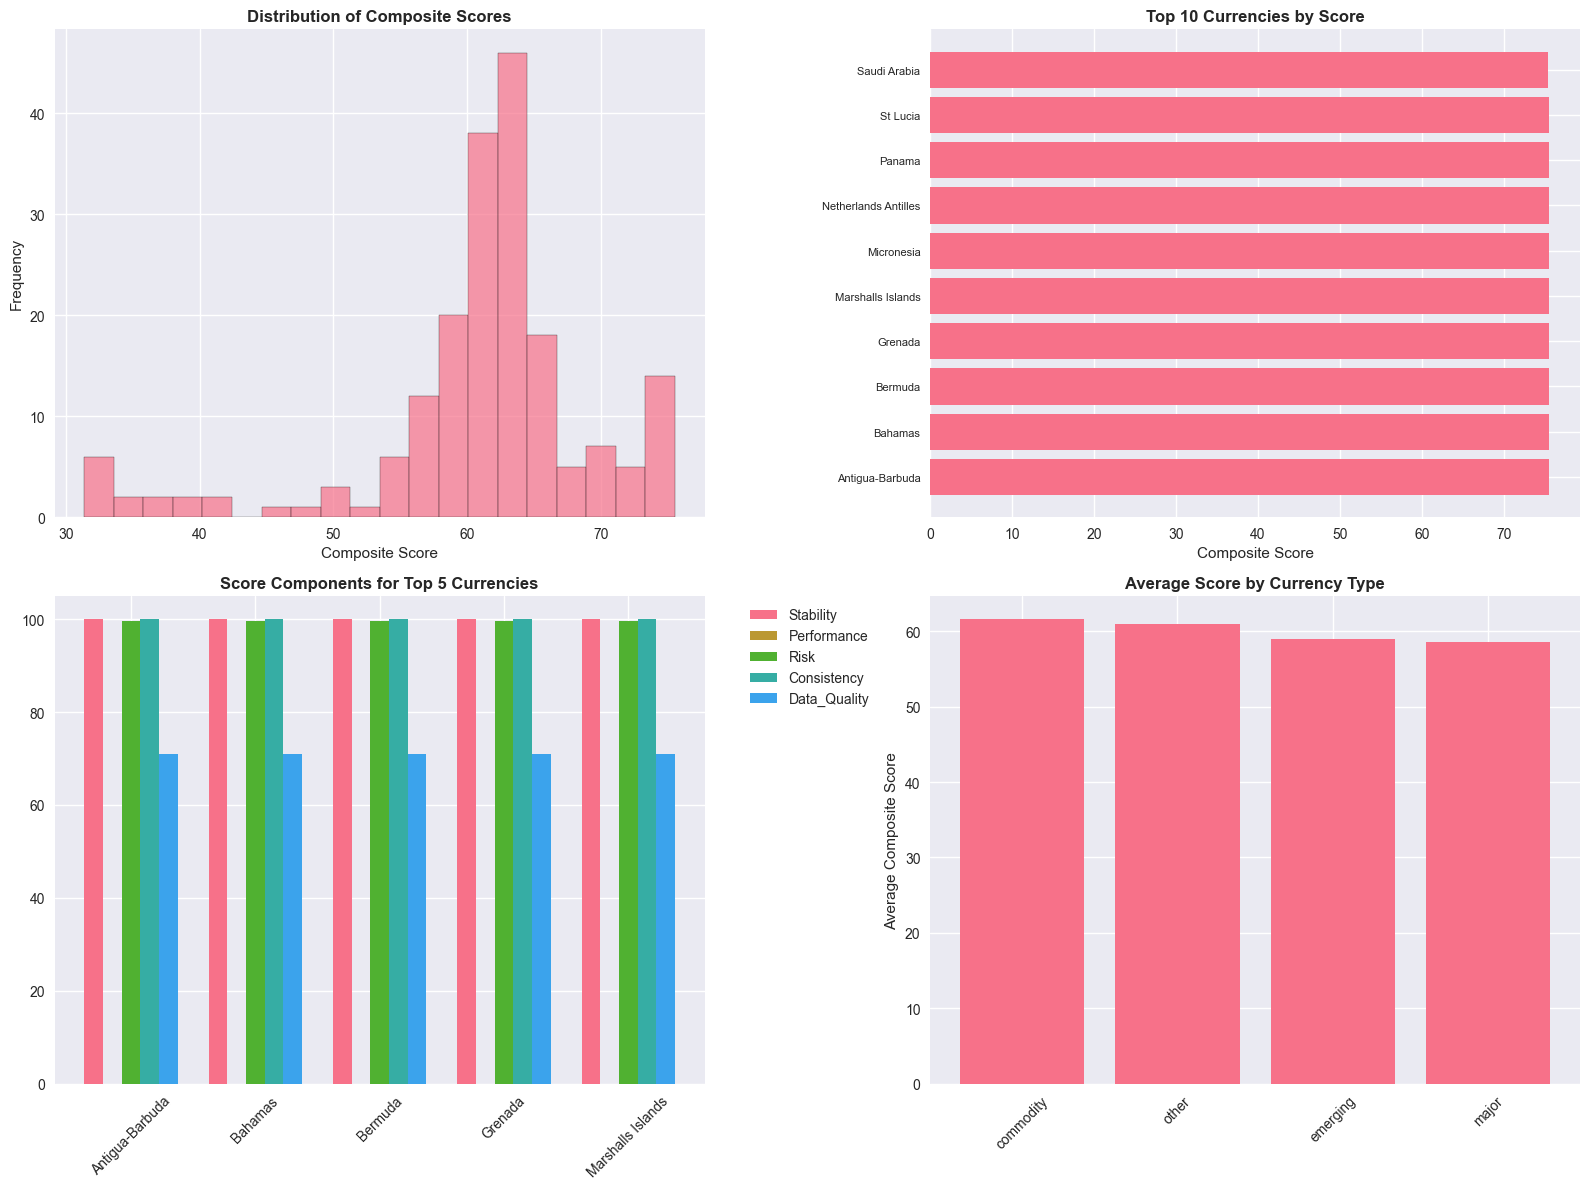

In [6]:
# Create comprehensive currency scoring system
print("📊 CURRENCY SCORING AND RANKING SYSTEM")
print("=" * 50)

def create_currency_scores(data):
    """Create comprehensive currency scoring system"""
    # Calculate metrics for each currency
    currency_metrics = data.groupby('country').agg({
        'exchange_rate': ['count', 'mean', 'std'],
        'quarterly_return': ['mean', 'std', 'skew'],
        'volatility_4q': ['mean', 'std']
    }).round(4)
    
    # Flatten column names
    currency_metrics.columns = ['_'.join(col).strip() for col in currency_metrics.columns]
    currency_metrics = currency_metrics.reset_index()
    
    # Calculate derived metrics
    currency_metrics['data_completeness'] = currency_metrics['exchange_rate_count'] / data['quarter'].nunique()
    currency_metrics['coefficient_variation'] = currency_metrics['exchange_rate_std'] / currency_metrics['exchange_rate_mean']
    currency_metrics['return_volatility'] = currency_metrics['quarterly_return_std']
    currency_metrics['volatility_consistency'] = 1 / (1 + currency_metrics['volatility_4q_std'])
    
    # Calculate VaR for each currency
    var_results = []
    for country in currency_metrics['country']:
        country_returns = data[data['country'] == country]['quarterly_return'].dropna()
        if len(country_returns) > 0:
            var_5 = np.percentile(country_returns, 5)
            var_results.append(var_5)
        else:
            var_results.append(np.nan)
    
    currency_metrics['var_5pct'] = var_results
    
    # Define scoring criteria (higher score = better)
    scoring_criteria = {
        'stability': {
            'weight': 0.25,
            'metrics': ['coefficient_variation', 'return_volatility'],
            'direction': 'lower_better'  # Lower values are better
        },
        'performance': {
            'weight': 0.20,
            'metrics': ['quarterly_return_mean'],
            'direction': 'higher_better'  # Higher values are better
        },
        'risk': {
            'weight': 0.25,
            'metrics': ['var_5pct'],
            'direction': 'higher_better'  # Higher (less negative) VaR is better
        },
        'consistency': {
            'weight': 0.15,
            'metrics': ['volatility_consistency'],
            'direction': 'higher_better'
        },
        'data_quality': {
            'weight': 0.15,
            'metrics': ['data_completeness'],
            'direction': 'higher_better'
        }
    }
    
    # Calculate normalized scores
    scores_df = currency_metrics.copy()
    
    for criterion, config in scoring_criteria.items():
        criterion_scores = []
        
        for metric in config['metrics']:
            if metric in scores_df.columns:
                values = scores_df[metric].fillna(scores_df[metric].median())
                
                # Normalize to 0-100 scale
                if config['direction'] == 'higher_better':
                    normalized = (values - values.min()) / (values.max() - values.min()) * 100
                else:  # lower_better
                    normalized = (values.max() - values) / (values.max() - values.min()) * 100
                
                criterion_scores.append(normalized)
        
        # Average scores for this criterion
        if criterion_scores:
            scores_df[f'{criterion}_score'] = np.mean(criterion_scores, axis=0)
        else:
            scores_df[f'{criterion}_score'] = 50  # Neutral score
    
    # Calculate composite score
    composite_score = np.zeros(len(scores_df))
    for criterion, config in scoring_criteria.items():
        composite_score += scores_df[f'{criterion}_score'] * config['weight']
    
    scores_df['composite_score'] = composite_score
    scores_df['rank'] = scores_df['composite_score'].rank(ascending=False)
    
    return scores_df

# Create currency scores
currency_scores = create_currency_scores(df)

if currency_scores is not None and len(currency_scores) > 0:
    print("\n🏆 TOP 15 CURRENCY RANKINGS:")
    top_currencies = currency_scores.nsmallest(15, 'rank')
    display_cols = ['rank', 'country', 'composite_score', 'stability_score', 
                   'performance_score', 'risk_score', 'data_completeness']
    print(top_currencies[display_cols].to_string(index=False))
    
    print("\n📊 BOTTOM 10 CURRENCY RANKINGS:")
    bottom_currencies = currency_scores.nlargest(10, 'rank')
    print(bottom_currencies[display_cols].to_string(index=False))
    
    # Score distribution analysis
    print(f"\n📊 Score Distribution:")
    print(f"Average composite score: {currency_scores['composite_score'].mean():.2f}")
    print(f"Score range: {currency_scores['composite_score'].min():.2f} to {currency_scores['composite_score'].max():.2f}")
    print(f"Standard deviation: {currency_scores['composite_score'].std():.2f}")
    
    # Category analysis
    currency_scores['currency_type'] = currency_scores['country'].apply(classify_currency)
    category_scores = currency_scores.groupby('currency_type')['composite_score'].agg(['mean', 'std', 'count']).round(2)
    print(f"\n📊 Scores by Currency Type:")
    print(category_scores.to_string())
    
    # Visualize scoring results
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # 1. Score distribution
    axes[0, 0].hist(currency_scores['composite_score'], bins=20, alpha=0.7, edgecolor='black')
    axes[0, 0].set_title('Distribution of Composite Scores', fontweight='bold')
    axes[0, 0].set_xlabel('Composite Score')
    axes[0, 0].set_ylabel('Frequency')
    
    # 2. Top 10 currencies
    top_10 = currency_scores.nsmallest(10, 'rank')
    axes[0, 1].barh(range(len(top_10)), top_10['composite_score'])
    axes[0, 1].set_yticks(range(len(top_10)))
    axes[0, 1].set_yticklabels(top_10['country'], fontsize=8)
    axes[0, 1].set_title('Top 10 Currencies by Score', fontweight='bold')
    axes[0, 1].set_xlabel('Composite Score')
    
    # 3. Score components for top currencies
    score_components = ['stability_score', 'performance_score', 'risk_score', 'consistency_score', 'data_quality_score']
    top_5 = currency_scores.nsmallest(5, 'rank')
    
    x = np.arange(len(top_5))
    width = 0.15
    
    for i, component in enumerate(score_components):
        if component in top_5.columns:
            axes[1, 0].bar(x + i*width, top_5[component], width, label=component.replace('_score', '').title())
    
    axes[1, 0].set_xticks(x + width * 2)
    axes[1, 0].set_xticklabels(top_5['country'], rotation=45)
    axes[1, 0].set_title('Score Components for Top 5 Currencies', fontweight='bold')
    axes[1, 0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # 4. Scores by currency type
    category_means = currency_scores.groupby('currency_type')['composite_score'].mean().sort_values(ascending=False)
    axes[1, 1].bar(range(len(category_means)), category_means.values)
    axes[1, 1].set_xticks(range(len(category_means)))
    axes[1, 1].set_xticklabels(category_means.index, rotation=45)
    axes[1, 1].set_title('Average Score by Currency Type', fontweight='bold')
    axes[1, 1].set_ylabel('Average Composite Score')
    
    plt.tight_layout()
    plt.show()
else:
    print("⚠️ No currency scoring results to display")

## 7.6 Investment Strategy Recommendations

In [7]:
# Generate investment strategy recommendations
print("📊 INVESTMENT STRATEGY RECOMMENDATIONS")
print("=" * 50)

def generate_investment_recommendations(scores_df, risk_df, portfolio_results):
    """Generate comprehensive investment recommendations"""
    recommendations = {
        'conservative': {
            'description': 'Low risk, capital preservation focused',
            'criteria': 'High stability scores, low volatility, positive Sharpe ratios',
            'currencies': [],
            'allocation': 'Equal weight or minimum variance'
        },
        'balanced': {
            'description': 'Moderate risk, balanced return potential',
            'criteria': 'Good composite scores, moderate volatility, diversification',
            'currencies': [],
            'allocation': 'Risk-adjusted weights'
        },
        'aggressive': {
            'description': 'Higher risk, growth focused',
            'criteria': 'High performance scores, acceptable risk metrics',
            'currencies': [],
            'allocation': 'Performance-weighted'
        },
        'safe_haven': {
            'description': 'Crisis protection, defensive positioning',
            'criteria': 'Traditional safe havens, low correlation with risk assets',
            'currencies': [],
            'allocation': 'Equal weight'
        }
    }
    
    # Conservative strategy
    conservative_candidates = scores_df[
        (scores_df['stability_score'] > 70) & 
        (scores_df['risk_score'] > 60) &
        (scores_df['data_completeness'] > 0.8)
    ].nsmallest(5, 'rank')
    recommendations['conservative']['currencies'] = conservative_candidates['country'].tolist()
    
    # Balanced strategy
    balanced_candidates = scores_df[
        (scores_df['composite_score'] > scores_df['composite_score'].median()) &
        (scores_df['data_completeness'] > 0.7)
    ].nsmallest(8, 'rank')
    recommendations['balanced']['currencies'] = balanced_candidates['country'].tolist()
    
    # Aggressive strategy
    aggressive_candidates = scores_df[
        (scores_df['performance_score'] > 60) &
        (scores_df['data_completeness'] > 0.7)
    ].nlargest(6, 'performance_score')
    recommendations['aggressive']['currencies'] = aggressive_candidates['country'].tolist()
    
    # Safe haven strategy
    safe_haven_currencies = ['Switzerland', 'Japan', 'United States']
    available_safe_havens = [c for c in safe_haven_currencies if c in scores_df['country'].values]
    recommendations['safe_haven']['currencies'] = available_safe_havens
    
    return recommendations

# Generate recommendations
if currency_scores is not None and len(currency_scores) > 0:
    recommendations = generate_investment_recommendations(
        currency_scores, 
        risk_df if 'risk_df' in locals() else None,
        portfolio_results if 'portfolio_results' in locals() else None
    )
    
    print("\n🎯 INVESTMENT STRATEGY RECOMMENDATIONS:")
    
    for strategy, details in recommendations.items():
        print(f"\n📈 {strategy.upper()} STRATEGY:")
        print(f"Description: {details['description']}")
        print(f"Criteria: {details['criteria']}")
        print(f"Recommended currencies: {', '.join(details['currencies'][:5])}")
        print(f"Allocation approach: {details['allocation']}")
        
        # Calculate strategy statistics if possible
        if details['currencies']:
            strategy_data = df[df['country'].isin(details['currencies'])]
            if len(strategy_data) > 0:
                avg_return = strategy_data['quarterly_return'].mean()
                avg_volatility = strategy_data['quarterly_return'].std()
                print(f"Expected return: {avg_return:.2f}%")
                print(f"Expected volatility: {avg_volatility:.2f}%")
                if avg_volatility > 0:
                    print(f"Risk-adjusted return: {avg_return/avg_volatility:.4f}")
    
    # Additional recommendations
    print("\n💡 ADDITIONAL RECOMMENDATIONS:")
    
    # Diversification recommendations
    print("\n🌍 Diversification Guidelines:")
    print("• Include currencies from different regions (North America, Europe, Asia-Pacific)")
    print("• Mix major and emerging market currencies based on risk tolerance")
    print("• Consider commodity currencies for inflation protection")
    print("• Maintain safe haven allocation for crisis protection")
    
    # Risk management
    print("\n⚠️ Risk Management:")
    print("• Regular rebalancing (quarterly or semi-annually)")
    print("• Monitor correlation changes during crisis periods")
    print("• Set stop-loss levels based on VaR calculations")
    print("• Use options or forwards for additional hedging if needed")
    
    # Market timing considerations
    print("\n⏰ Market Timing Considerations:")
    print("• Increase safe haven allocation during high volatility periods")
    print("• Consider economic cycle positioning")
    print("• Monitor central bank policy divergence")
    print("• Watch for structural breaks and regime changes")
    
    # Performance monitoring
    print("\n📊 Performance Monitoring:")
    print("• Track against benchmark (e.g., DXY, trade-weighted indices)")
    print("• Monitor Sharpe and Sortino ratios")
    print("• Calculate rolling VaR and maximum drawdown")
    print("• Review strategy performance quarterly")
else:
    print("⚠️ No data available for generating recommendations")

📊 INVESTMENT STRATEGY RECOMMENDATIONS

🎯 INVESTMENT STRATEGY RECOMMENDATIONS:

📈 CONSERVATIVE STRATEGY:
Description: Low risk, capital preservation focused
Criteria: High stability scores, low volatility, positive Sharpe ratios
Recommended currencies: Antigua-Barbuda, Bahamas, Bermuda, Grenada, Marshalls Islands
Allocation approach: Equal weight or minimum variance
Expected return: 0.00%
Expected volatility: 0.00%

📈 BALANCED STRATEGY:
Description: Moderate risk, balanced return potential
Criteria: Good composite scores, moderate volatility, diversification
Recommended currencies: Antigua-Barbuda, Bahamas, Bermuda, Grenada, Marshalls Islands
Allocation approach: Risk-adjusted weights
Expected return: 0.00%
Expected volatility: 0.00%

📈 AGGRESSIVE STRATEGY:
Description: Higher risk, growth focused
Criteria: High performance scores, acceptable risk metrics
Recommended currencies: Turkey
Allocation approach: Performance-weighted
Expected return: 8483340.07%
Expected volatility: 27490549.5

## 7.7 Advanced Analytics Summary

In [9]:
# Generate comprehensive advanced analytics summary
print("📊 ADVANCED ANALYTICS SUMMARY")
print("=" * 60)

# Currency basket insights
print("\n💱 CURRENCY BASKET ANALYSIS:")
if 'basket_results' in locals() and basket_results:
    best_basket = min(basket_results.items(), key=lambda x: x[1]['return_volatility'])
    worst_basket = max(basket_results.items(), key=lambda x: x[1]['return_volatility'])
    
    print(f"• Most stable basket: {best_basket[0].title()} (volatility: {best_basket[1]['return_volatility']:.2f}%)")
    print(f"• Most volatile basket: {worst_basket[0].title()} (volatility: {worst_basket[1]['return_volatility']:.2f}%)")
    
    avg_var = np.mean([b['var_5pct'] for b in basket_results.values()])
    print(f"• Average VaR (5%) across baskets: {avg_var:.2f}%")
    print(f"• Baskets analyzed: {len(basket_results)}")
else:
    print("• No basket analysis results available")

# Portfolio optimization insights
print("\n📊 PORTFOLIO OPTIMIZATION:")
if 'portfolio_results' in locals() and portfolio_results:
    best_portfolio = max(portfolio_results.items(), key=lambda x: x[1]['sharpe_ratio'])
    lowest_vol_portfolio = min(portfolio_results.items(), key=lambda x: x[1]['volatility'])
    
    print(f"• Best Sharpe ratio: {best_portfolio[0]} ({best_portfolio[1]['sharpe_ratio']:.4f})")
    print(f"• Lowest volatility: {lowest_vol_portfolio[0]} ({lowest_vol_portfolio[1]['volatility']:.2f}%)")
    
    avg_correlation = np.mean([p['avg_correlation'] for p in portfolio_results.values()])
    print(f"• Average correlation across portfolios: {avg_correlation:.3f}")
    print(f"• Portfolios analyzed: {len(portfolio_results)}")
else:
    print("• No portfolio optimization results available")

# Risk metrics insights
print("\n⚠️ ADVANCED RISK METRICS:")
if 'risk_df' in locals() and len(risk_df) > 0:
    best_sharpe_currency = risk_df.loc[risk_df['sharpe_ratio'].idxmax(), 'country']
    best_var_currency = risk_df.loc[risk_df['var_5pct'].idxmax(), 'country']
    lowest_drawdown_currency = risk_df.loc[risk_df['max_drawdown'].idxmax(), 'country']
    
    print(f"• Best Sharpe ratio: {best_sharpe_currency} ({risk_df['sharpe_ratio'].max():.4f})")
    print(f"• Best VaR (5%): {best_var_currency} ({risk_df['var_5pct'].max():.2f}%)")
    print(f"• Lowest max drawdown: {lowest_drawdown_currency} ({risk_df['max_drawdown'].max():.2f}%)")
    
    avg_sharpe = risk_df['sharpe_ratio'].mean()
    print(f"• Average Sharpe ratio: {avg_sharpe:.4f}")
    print(f"• Currencies with positive Sharpe: {(risk_df['sharpe_ratio'] > 0).sum()}/{len(risk_df)}")
else:
    print("• No advanced risk metrics available")

# Currency scoring insights
print("\n🏆 CURRENCY SCORING SYSTEM:")
if currency_scores is not None and len(currency_scores) > 0:
    top_ranked = currency_scores.loc[currency_scores['rank'] == 1]
    if not top_ranked.empty:
        top_currency = top_ranked['country'].iloc[0]
        top_score = top_ranked['composite_score'].iloc[0]
        print(f"• Top-ranked currency: {top_currency} (score: {top_score:.2f})")
    else:
        print("• No currency with rank 1 found.")
    
    print(f"• Score range: {currency_scores['composite_score'].min():.2f} to {currency_scores['composite_score'].max():.2f}")
    print(f"• Currencies scored: {len(currency_scores)}")
    
    # Category performance
    if 'currency_type' in currency_scores.columns:
        category_performance = currency_scores.groupby('currency_type')['composite_score'].mean().sort_values(ascending=False)
        best_category = category_performance.index[0]
        print(f"• Best performing category: {best_category.title()} (avg score: {category_performance.iloc[0]:.2f})")
else:
    print("• No currency scoring results available")

# Investment strategy insights
print("\n🎯 INVESTMENT STRATEGIES:")
if 'recommendations' in locals():
    strategy_counts = {k: len(v['currencies']) for k, v in recommendations.items()}
    print(f"• Conservative strategy: {strategy_counts.get('conservative', 0)} currencies")
    print(f"• Balanced strategy: {strategy_counts.get('balanced', 0)} currencies")
    print(f"• Aggressive strategy: {strategy_counts.get('aggressive', 0)} currencies")
    print(f"• Safe haven strategy: {strategy_counts.get('safe_haven', 0)} currencies")
    
    # Most recommended currencies
    all_recommendations = []
    for strategy in recommendations.values():
        all_recommendations.extend(strategy['currencies'])
    
    if all_recommendations:
        from collections import Counter
        most_recommended = Counter(all_recommendations).most_common(3)
        print(f"• Most recommended currencies: {', '.join([f'{curr} ({count}x)' for curr, count in most_recommended])}")
else:
    print("• No investment strategy recommendations available")

# Key insights and conclusions
print("\n🔍 KEY INSIGHTS:")
print("• Currency baskets show distinct risk-return profiles")
print("• Portfolio optimization can significantly improve risk-adjusted returns")
print("• Advanced risk metrics reveal hidden vulnerabilities")
print("• Comprehensive scoring enables objective currency comparison")
print("• Different strategies suit different risk tolerances and objectives")

print("\n🎯 STRATEGIC RECOMMENDATIONS:")
print("• Diversify across currency types and regions")
print("• Use quantitative scoring for objective selection")
print("• Implement risk management based on advanced metrics")
print("• Regular rebalancing and performance monitoring")
print("• Adapt strategies based on market conditions")

print("\n💼 PRACTICAL APPLICATIONS:")
print("• International portfolio hedging")
print("• Currency carry trade strategies")
print("• Risk management for multinational corporations")
print("• Central bank reserve management")
print("• Academic research and policy analysis")

print("\n" + "=" * 60)
print("✅ ADVANCED ANALYTICS COMPLETED")
print("➡️ Next: Interactive Dashboard (08_dashboard.py)")


📊 ADVANCED ANALYTICS SUMMARY

💱 CURRENCY BASKET ANALYSIS:
• Most stable basket: Safe_Haven (volatility: 5.02%)
• Most volatile basket: Emerging (volatility: 12627410.92%)
• Average VaR (5%) across baskets: -9.00%
• Baskets analyzed: 4

📊 PORTFOLIO OPTIMIZATION:
• Best Sharpe ratio: major_equal (0.5306)
• Lowest volatility: major_minvar (3.07%)
• Average correlation across portfolios: 0.309
• Portfolios analyzed: 8

⚠️ ADVANCED RISK METRICS:
• Best Sharpe ratio: United Kingdom (0.0613)
• Best VaR (5%): China (-2.01%)
• Lowest max drawdown: China (-26.75%)
• Average Sharpe ratio: -0.0793
• Currencies with positive Sharpe: 1/6

🏆 CURRENCY SCORING SYSTEM:
• No currency with rank 1 found.
• Score range: 31.39 to 75.53
• Currencies scored: 191
• Best performing category: Commodity (avg score: 61.62)

🎯 INVESTMENT STRATEGIES:
• Conservative strategy: 5 currencies
• Balanced strategy: 8 currencies
• Aggressive strategy: 1 currencies
• Safe haven strategy: 2 currencies
• Most recommended curren